# `Problem statement (Term Deposit Sale)`
## `Goal`
Using the data collected from existing customers, build a model that will help the marketing team identify potential customers who are relatively more likely to subscribe term deposit and thus increase their hit ratio.

# Attribute information
## Input variables:
### Bank client data:
1. age: Continuous feature
2. job: Type of job (management, technician, entrepreneur, blue-collar, etc.)
3. marital: marital status (married, single, divorced)
4. education: education level (primary, secondary, tertiary)
5. default: has credit in default?
6. housing: has housing loan?
7. loan: has personal loan?
8. balance in account
### Related to previous contact:
9. contact: contact communication type
10. month: last contact month of year
11. day: last contact day of the month
12. duration: last contact duration, in seconds*
### Other attributes:
13. campaign: number of contacts performed during this campaign and for this client
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (-1 tells us the person has not been contacted or contact period is beyond 900 days)
15. previous: number of times the client has been contacted before for the last campaign to subscribe term deposit
16. poutcome: outcome of the previous marketing campaign
### Output variable (desired target):
17. Target: Tell us has the client subscribed a term deposit. (Yes, No)

# Resources Available
The historical data for this project is available in file
https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

# Import Libraries and Load Dataset

In [71]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
#from sklearn.feature_extraction.text import CountVectorizer  #DT does not take strings as input for the model fit step....
from IPython.display import Image  
#import pydotplus as pydot
from sklearn import tree
from os import system

In [72]:
bankClientData = pd.read_csv('bank-full.csv')
bankClientData.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [73]:
bankClientData.shape

(45211, 17)

In [74]:
bankClientData.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Observations:

I see negative balance so have to find more to see if it is by mistake

Looks like there are high number of -1 in pdays


In [75]:
# No missing values
bankClientData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


##### Fortunately, there are no missing values. If there were missing values we will have to fill them with the median, mean or mode but in this case there is no need to fill any missing values. This will definitely make our job easier!

Many columns are of type object i.e. strings. These need to be converted to ordinal type.

Lets convert the columns with an 'object' datatype into categorical variables

In [76]:
for feature in bankClientData.columns: # Loop through all columns in the dataframe
    if bankClientData[feature].dtype == 'object': # Only apply for columns with categorical strings
        bankClientData[feature] = pd.Categorical(bankClientData[feature])# Replace strings with an integer
bankClientData.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


## Let us look at the target column which is 'Target' to understand how the data is distributed amongst the various values


In [77]:
bankClientData.groupby(["Target"]).mean()

,age,balance,day,duration,campaign,pdays,previous
Target,,,,,,,
no,40.838986,1303.714969,15.892290,221.182806,2.846350,36.421372,0.502154
yes,41.670070,1804.267915,15.158253,537.294574,2.141047,68.702968,1.170354


In [78]:
bankClientData.groupby(["Target"]).median()

,age,balance,day,duration,campaign,pdays,previous
Target,,,,,,,
no,39,417,16,164,2,-1,0
yes,38,733,15,426,2,-1,0


In [79]:
bankClientData[['job','marital','education','default','housing','loan','contact','month','poutcome','Target']].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,Target
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


# Observation:

Data contains more blue-collared jobs , married clients and clients with secondary education

In [80]:
print(bankClientData.job.value_counts())
print(bankClientData.marital.value_counts())
print(bankClientData.education.value_counts())
print(bankClientData.default.value_counts())
print(bankClientData.housing.value_counts())
print(bankClientData.loan.value_counts())
print(bankClientData.contact.value_counts())
print(bankClientData.day.value_counts())
print(bankClientData.month.value_counts())
print(bankClientData.duration.value_counts())
print(bankClientData.campaign.value_counts())
print(bankClientData.pdays.value_counts())
print(bankClientData.previous.value_counts())
print(bankClientData.poutcome.value_counts())

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64
no     44396
yes      815
Name: default, dtype: int64
yes    25130
no     20081
Name: housing, dtype: int64
no     37967
yes     7244
Name: loan, dtype: int64
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64
20    2752
18    2308
21    2026
17    1939
6     1932
5     1910
14    1848
8     1842
28    1830
7     1817
19    1757
29    1745
15    1703
12    1603
13    1585
30    1566
9     1561
11    1479
4     1445
16    1415
2     1293
27    1121
3     1079
26    1035
23     939
22   

# Using univariate analysis check the individual attributes for their basic statistic such as central values, spread, tails etc.

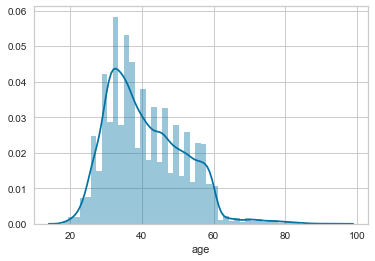

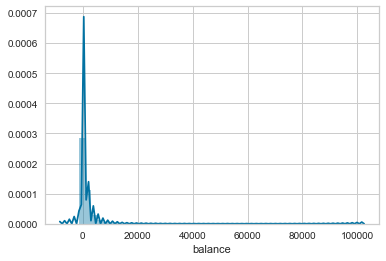

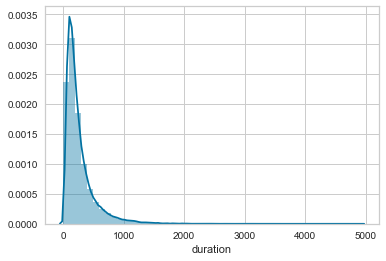

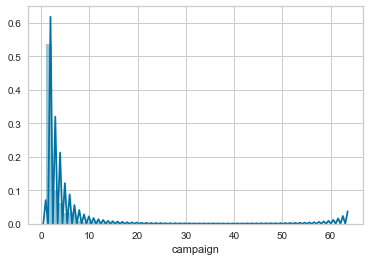

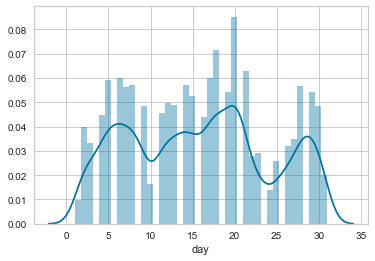

In [81]:
for  col in ['age', 'balance', 'duration', 'campaign', 'day'] :
    sns.distplot(bankClientData[col])
    plt.show()

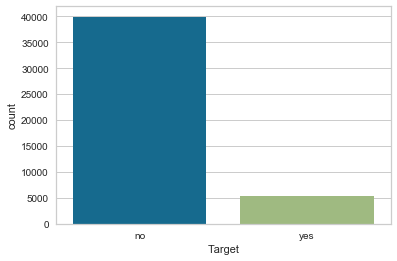

In [82]:
sns.countplot(bankClientData['Target'])

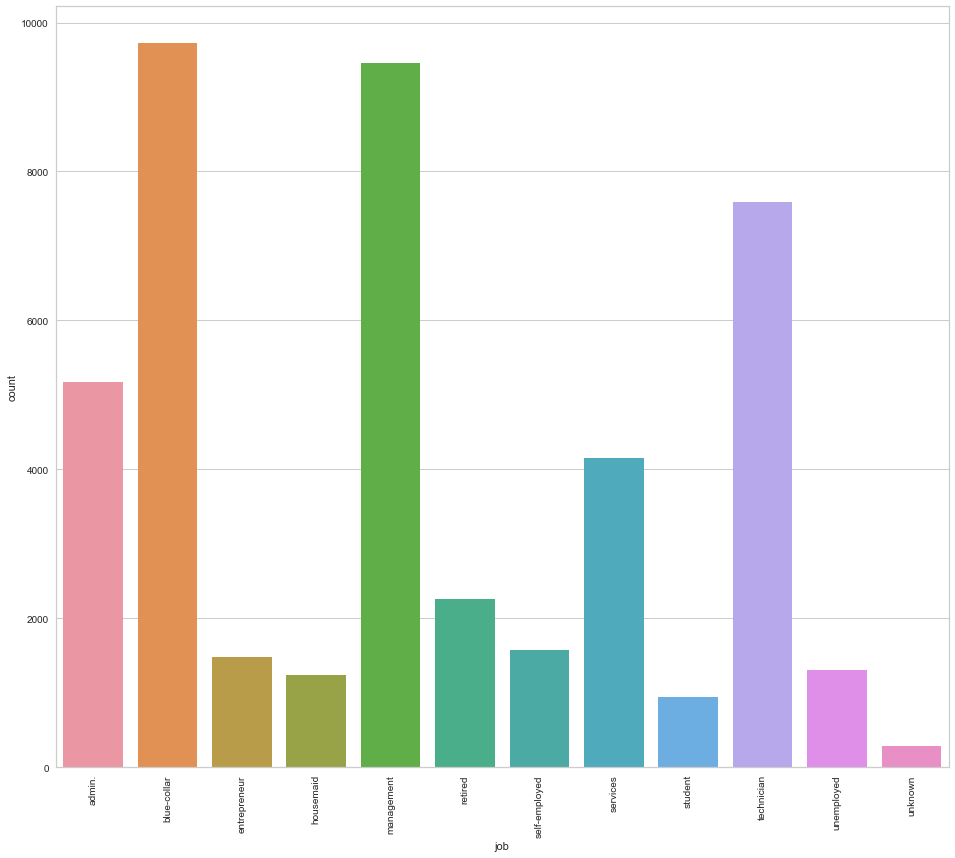

In [83]:
plt.figure(figsize=(16,14))
jobPlot = sns.countplot(x='job', data=bankClientData)
jobPlot.set_xticklabels(jobPlot.get_xticklabels(), rotation=90);

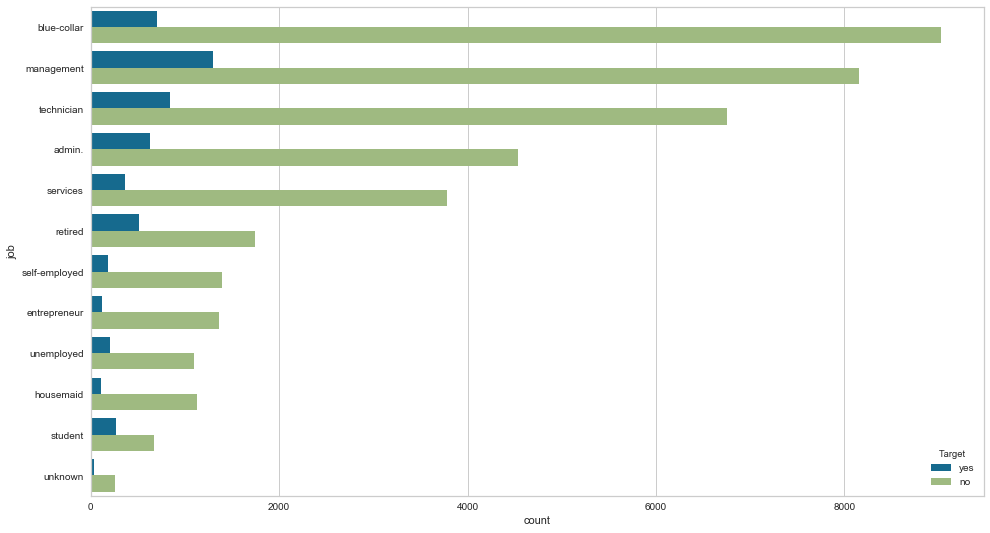

In [84]:
plt.figure(figsize=(16,9))
sns.countplot(y=bankClientData['job'], order=bankClientData['job'].value_counts().index, hue_order=['yes','no' ], hue=bankClientData['Target'])

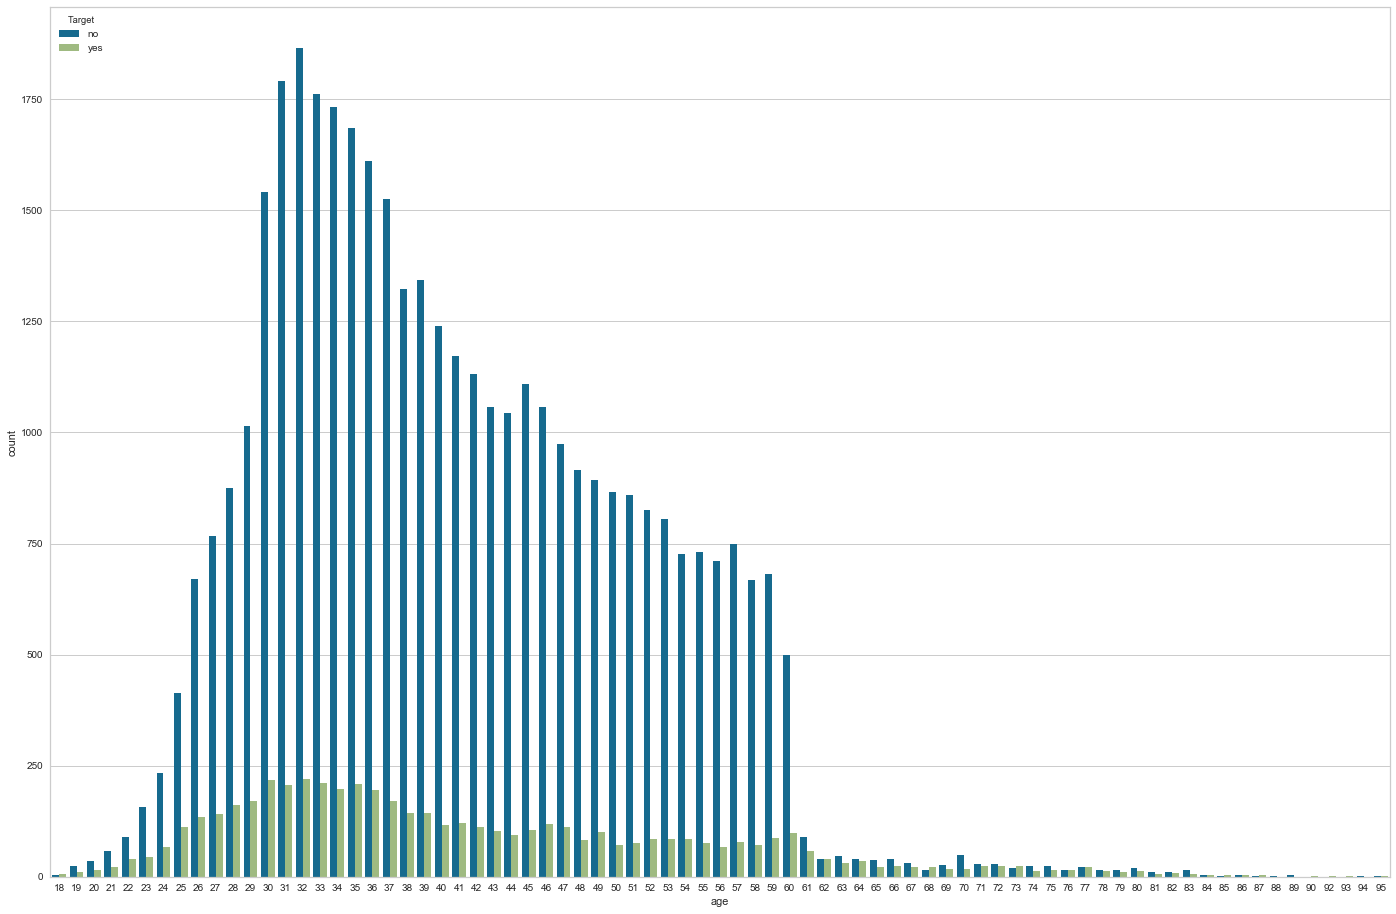

In [85]:
plt.figure(figsize=(24,16))
sns.countplot(bankClientData['age'], hue=bankClientData['Target'])

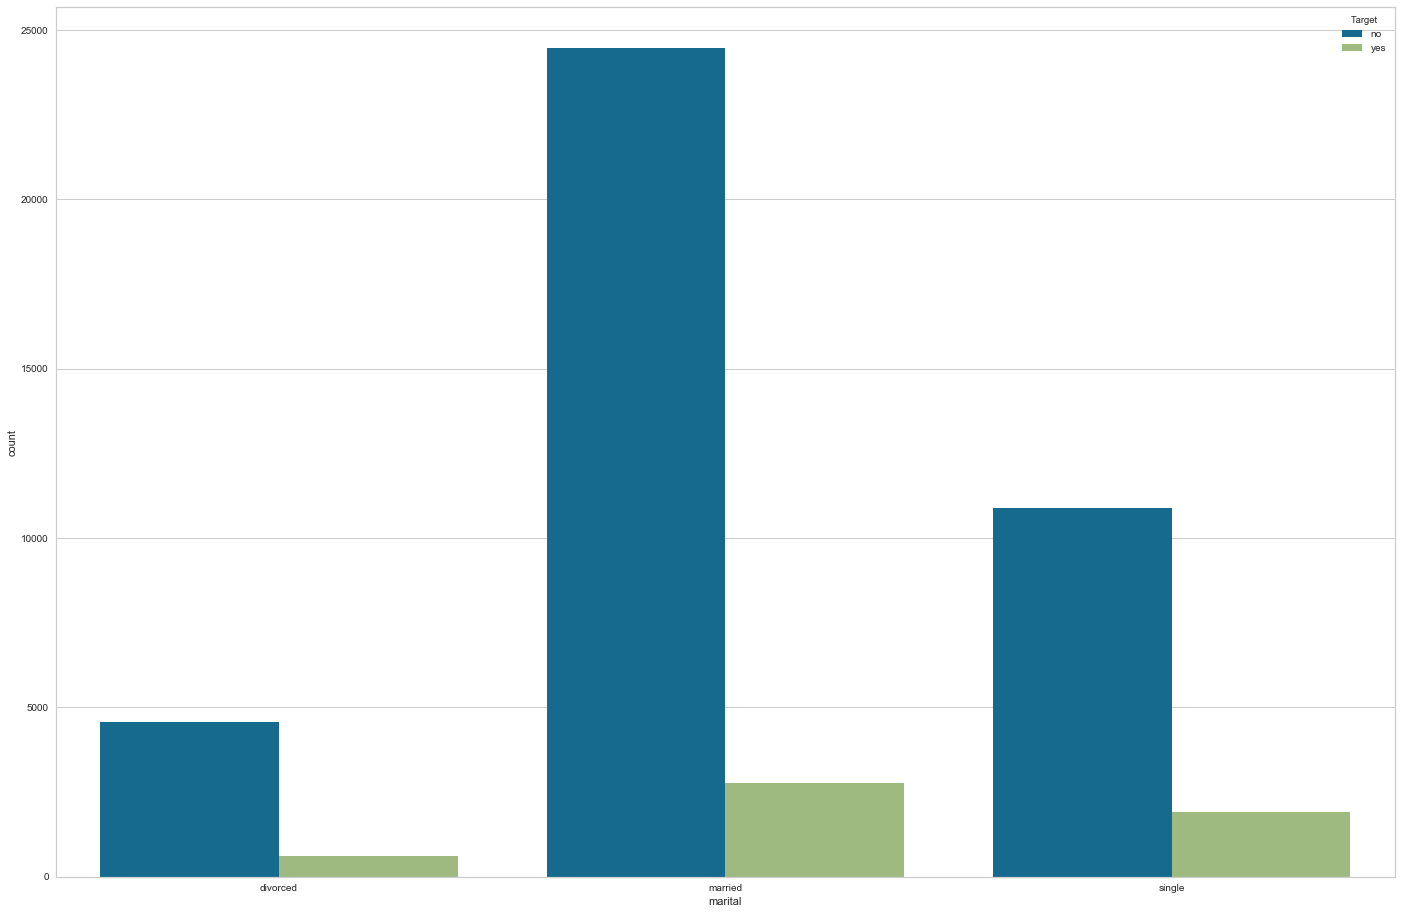

In [86]:
plt.figure(figsize=(24,16))
sns.countplot(bankClientData['marital'], hue=bankClientData['Target'])

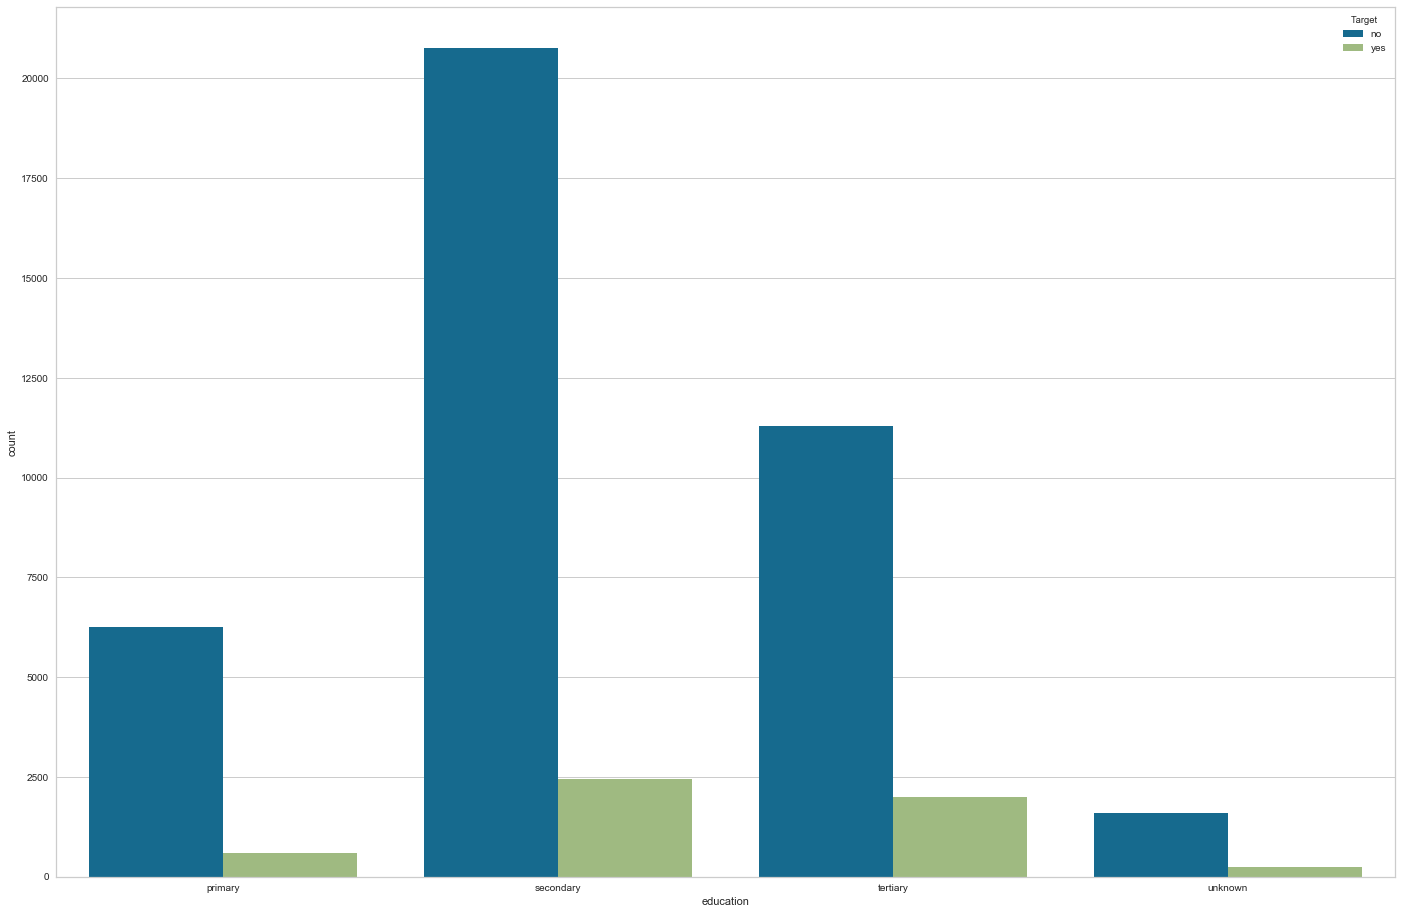

In [87]:
plt.figure(figsize=(24,16))
sns.countplot(bankClientData['education'], hue=bankClientData['Target'])

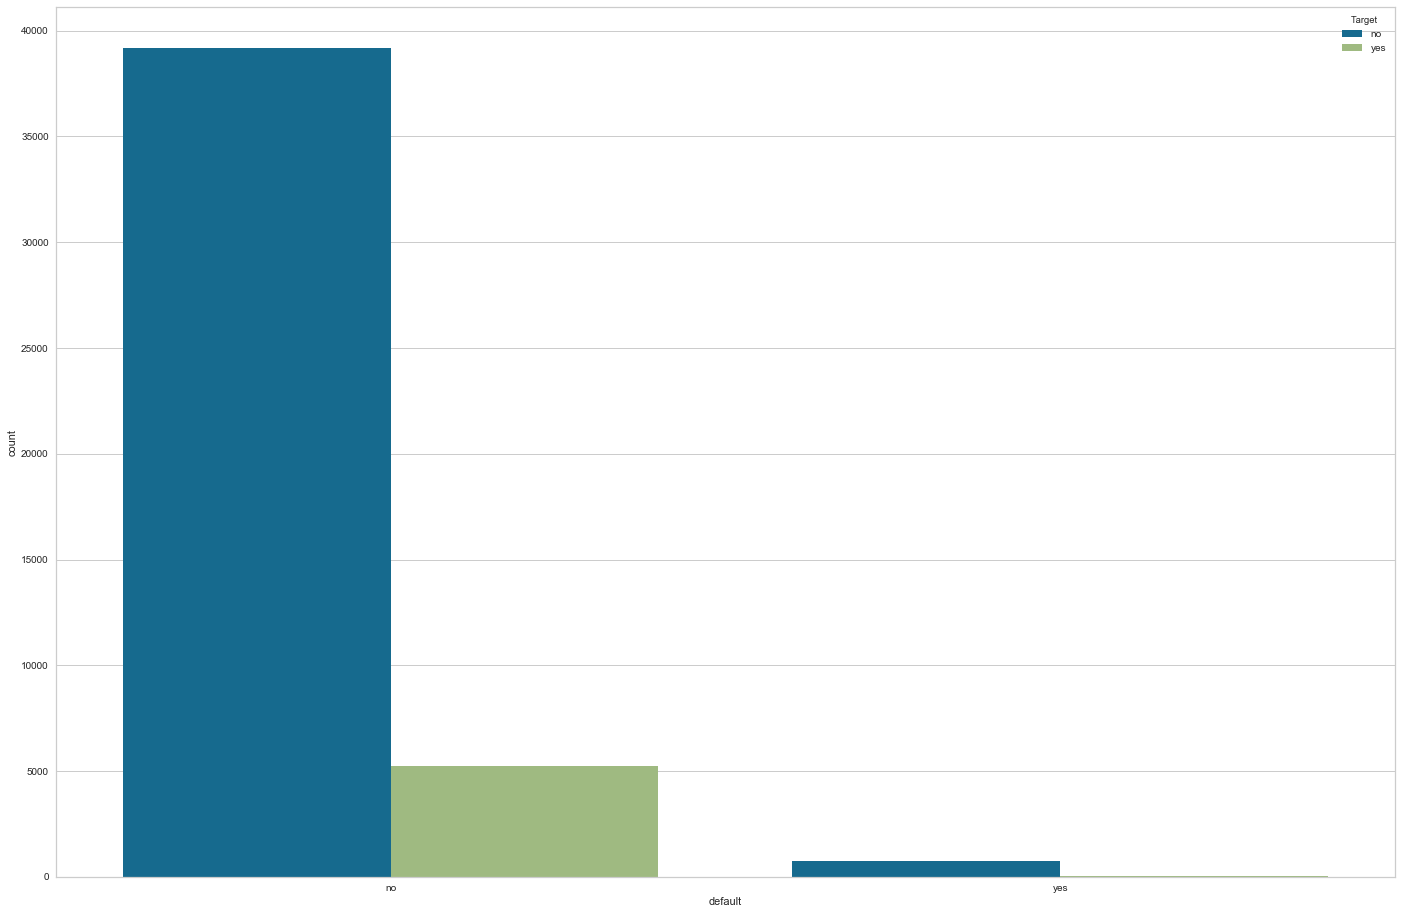

In [88]:
plt.figure(figsize=(24,16))
sns.countplot(bankClientData['default'], hue=bankClientData['Target'])

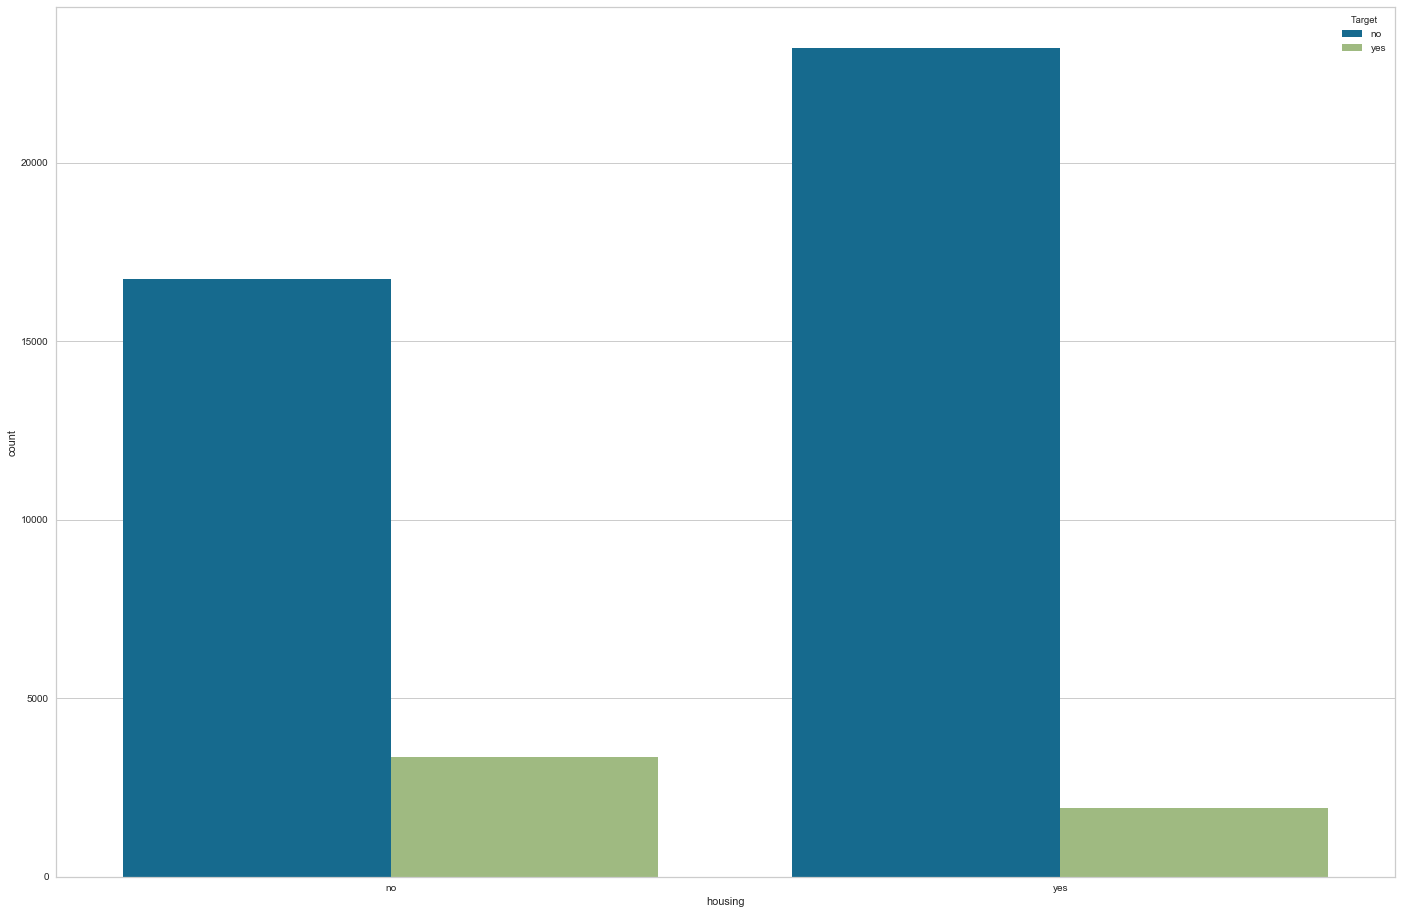

In [89]:
plt.figure(figsize=(24,16))
sns.countplot(bankClientData['housing'], hue=bankClientData['Target'])

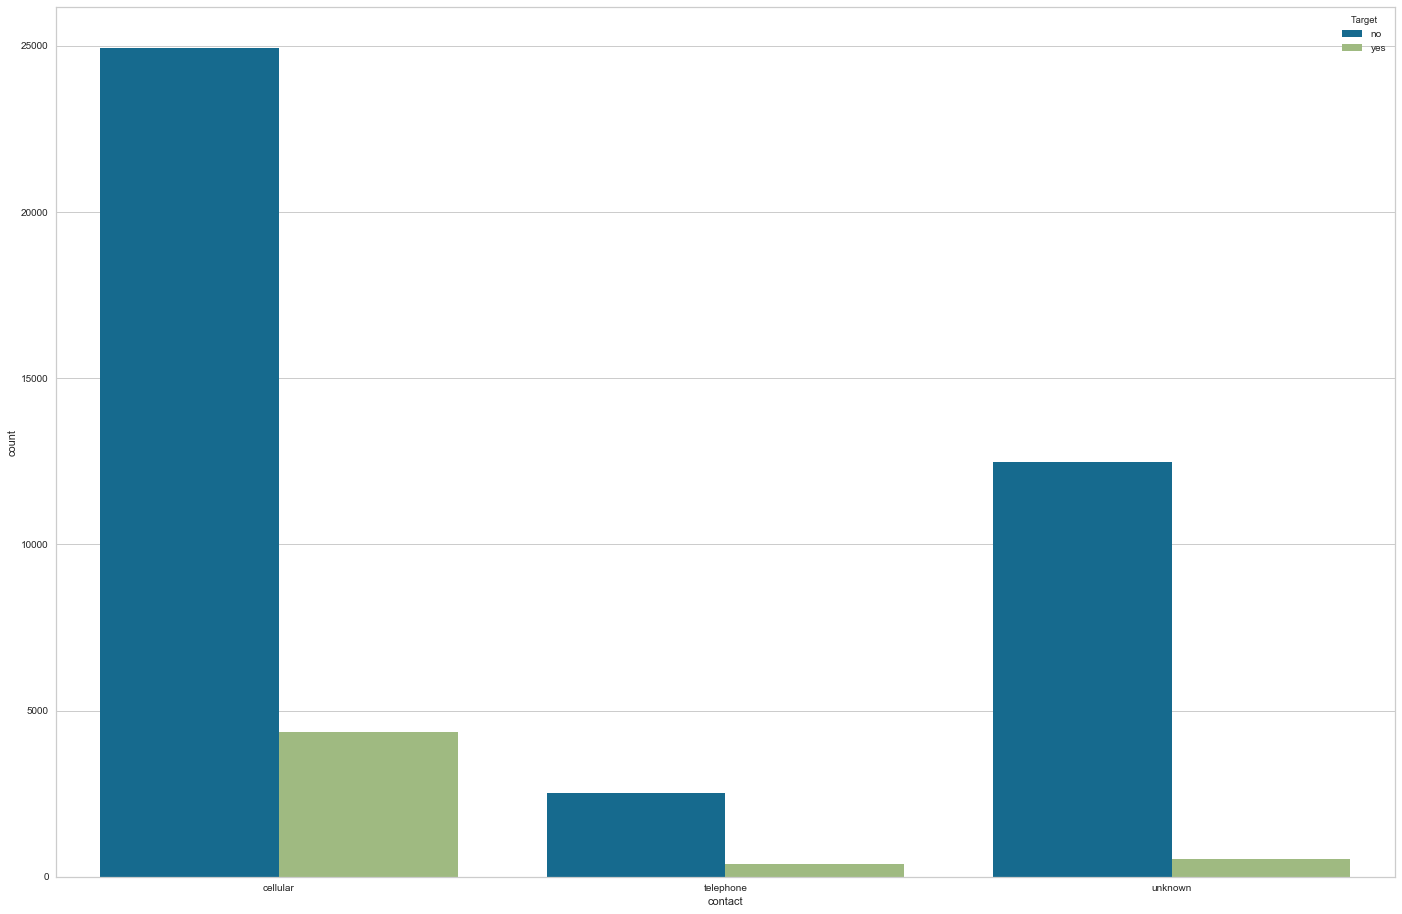

In [90]:
plt.figure(figsize=(24,16))
sns.countplot(bankClientData['contact'], hue=bankClientData['Target'])

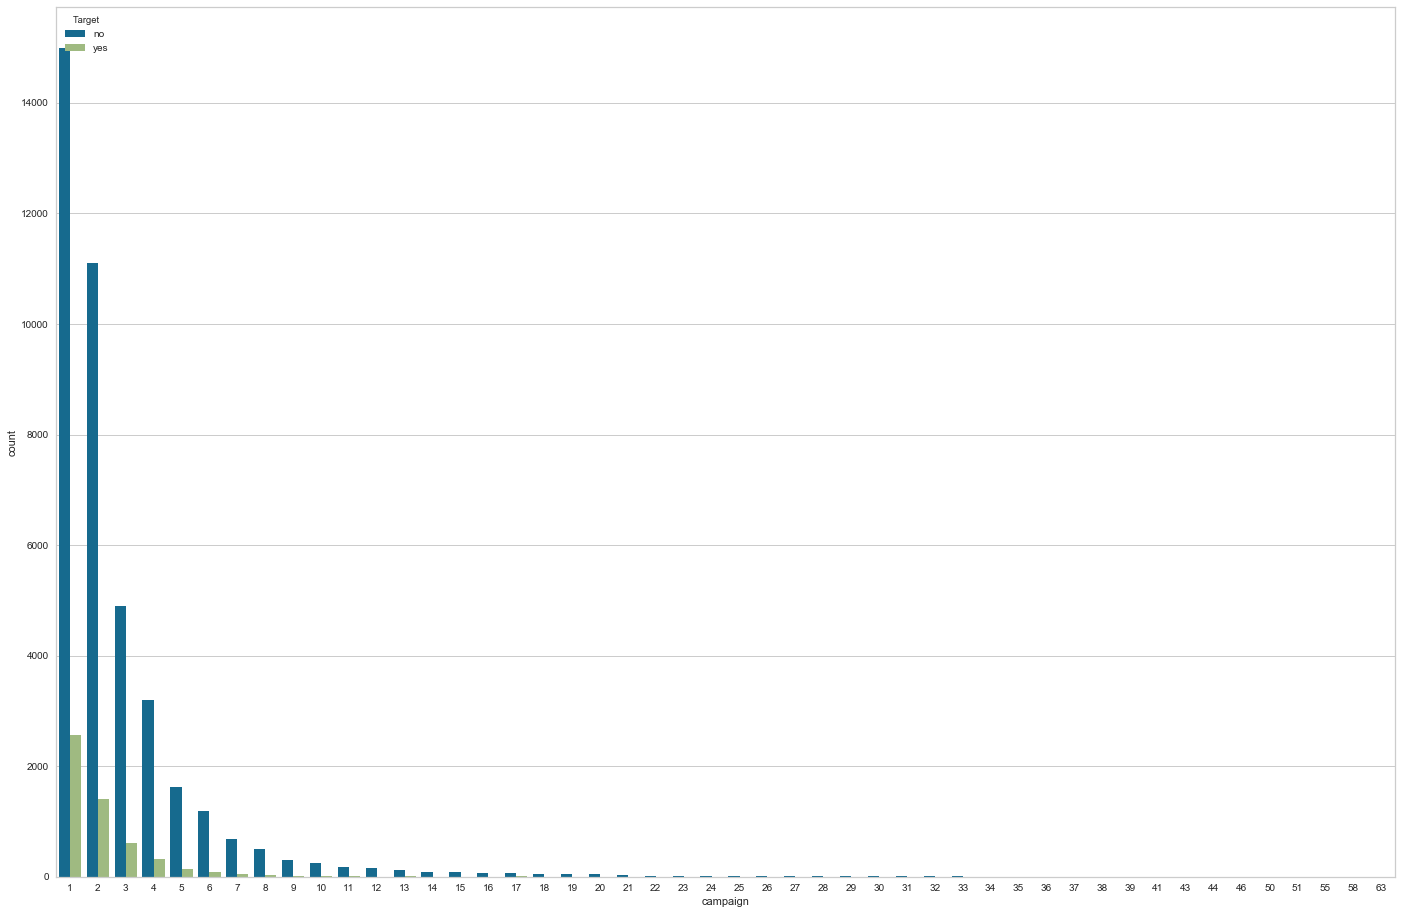

In [91]:
plt.figure(figsize=(24,16))
sns.countplot(bankClientData['campaign'], hue=bankClientData['Target'])

# Observation:

Management holder got more subscribtion to term deposit.
Client of age group 25-40 got more subscribtion to term deposit.
Married client got more subscribtion to term deposit.
Secondary educated got more subscribtion to term deposit.
Client with no default got more subscribtion to term deposit.
Clent with no housing loan got more subscribtion to term deposit.

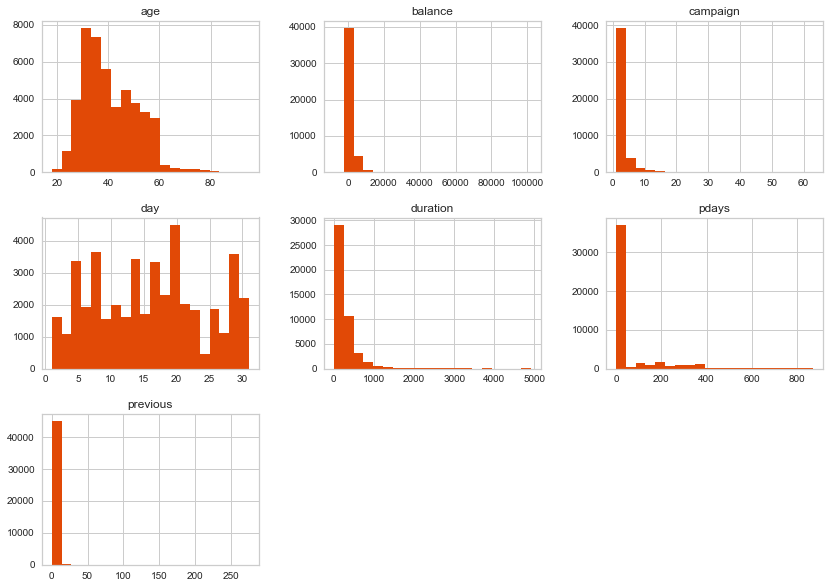

In [92]:
# histogram of continuous variables
bankClientData.hist(bins=20, figsize=(14,10), color='#E14906')
plt.show()

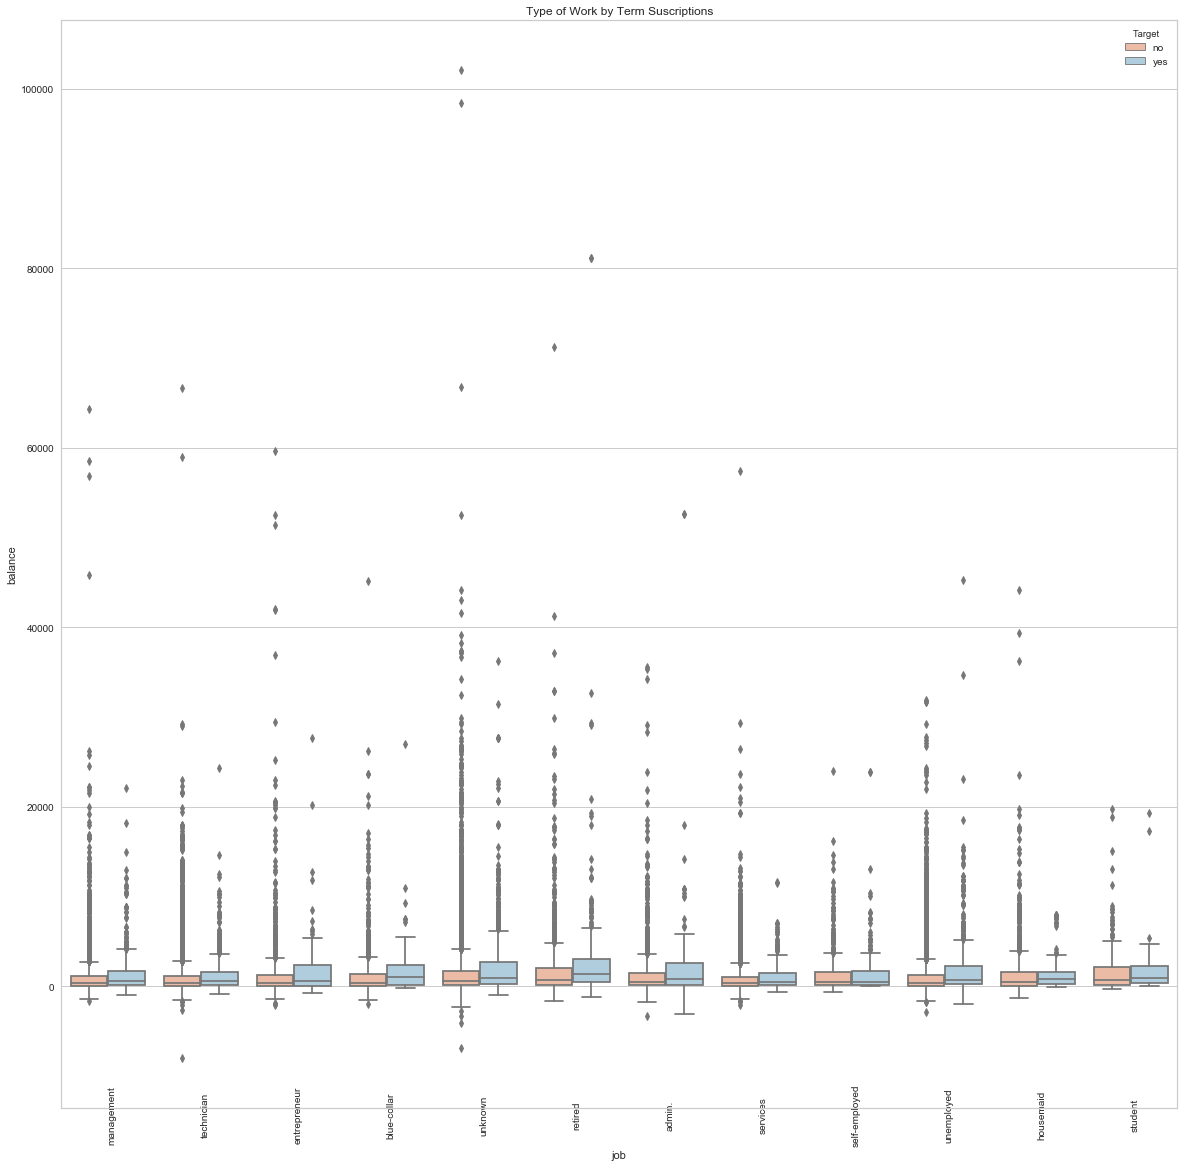

In [93]:
# boxplot of job vs balance with hue = Target
plt.figure(figsize=(20,20))
bplot = sns.boxplot(x="job", y="balance", hue="Target", data=bankClientData, palette="RdBu")
bplot.set_xticklabels(bankClientData["job"].unique(), rotation=90, rotation_mode="anchor")
bplot.set_title("Type of Work by Term Suscriptions")
plt.show()

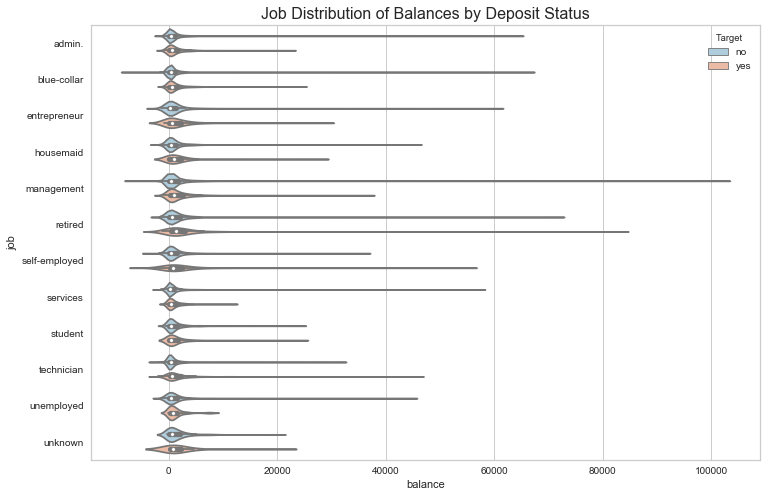

In [94]:
# violinplot
fig = plt.figure(figsize=(12,8))
sns.violinplot(x="balance", y="job", hue="Target", palette="RdBu_r", data=bankClientData);
plt.title("Job Distribution of Balances by Deposit Status", fontsize=16)
plt.show()

#### Occupation:
* Number of Occupations: Management is the occupation that is more prevalent in this dataset.
* Age by Occupation: As expected, the retired are the ones who have the highest median age while student are the lowest.
* Balance by Occupation: Management and Retirees are the ones who have the highest balance in their accounts.

# Use correlation method to observe the relationship between different variables and state your insights.

In [95]:
# relpace target variable no with 0 and yes with 1
bankClientData['Target'].replace(['no','yes'],[0,1],inplace = True)
bankClientData.head(20)
print(bankClientData.dtypes)

age             int64
job          category
marital      category
education    category
default      category
balance         int64
housing      category
loan         category
contact      category
day             int64
month        category
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome     category
Target          int64
dtype: object


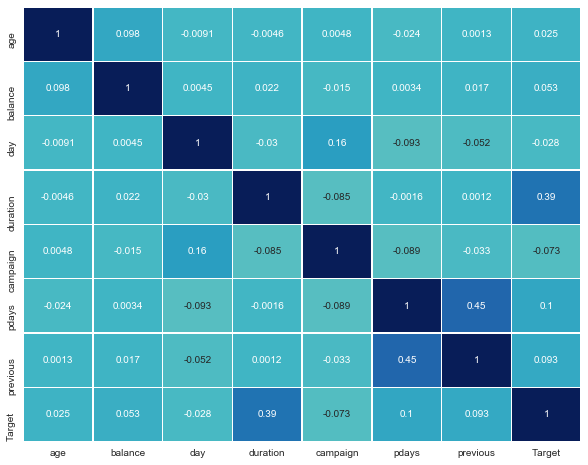

In [96]:
# heatmap or correlation
plt.figure(figsize=(10,8))

sns.heatmap(bankClientData.corr(),
             annot=True,
             linewidths=.5,
             center=0,
             cbar=False,
             cmap="YlGnBu")

plt.show()

# Summary:

Mean Age is aproximately 41 years old. (Minimum: 18 years old and Maximum: 95 years old.)

The mean balance is 1362.2. However, the Standard Deviation (std) is a high number so we can understand through this that the balance is heavily distributed across the dataset.

As the data information said it will be better to drop the duration column since duration is highly correlated in whether a potential client will buy a term deposit. Also, duration is obtained after the call is made to the potential client so if the target client has never received calls this feature is not that useful. The reason why duration is highly correlated with opening a term deposit is because the more the bank talks to a target client the higher the probability the target client will open a term deposit since a higher duration means a higher interest (commitment) from the potential client.

#### Duration:
Duration: We see that duration has a high correlation with term deposits meaning the higher the duration, the more likely it is for a client to open a term deposit.

#### Note: There are not that much insights we can gain from the descriptive dataset since most of our descriptive data is located not in the "numeric" columns but in the "categorical columns".

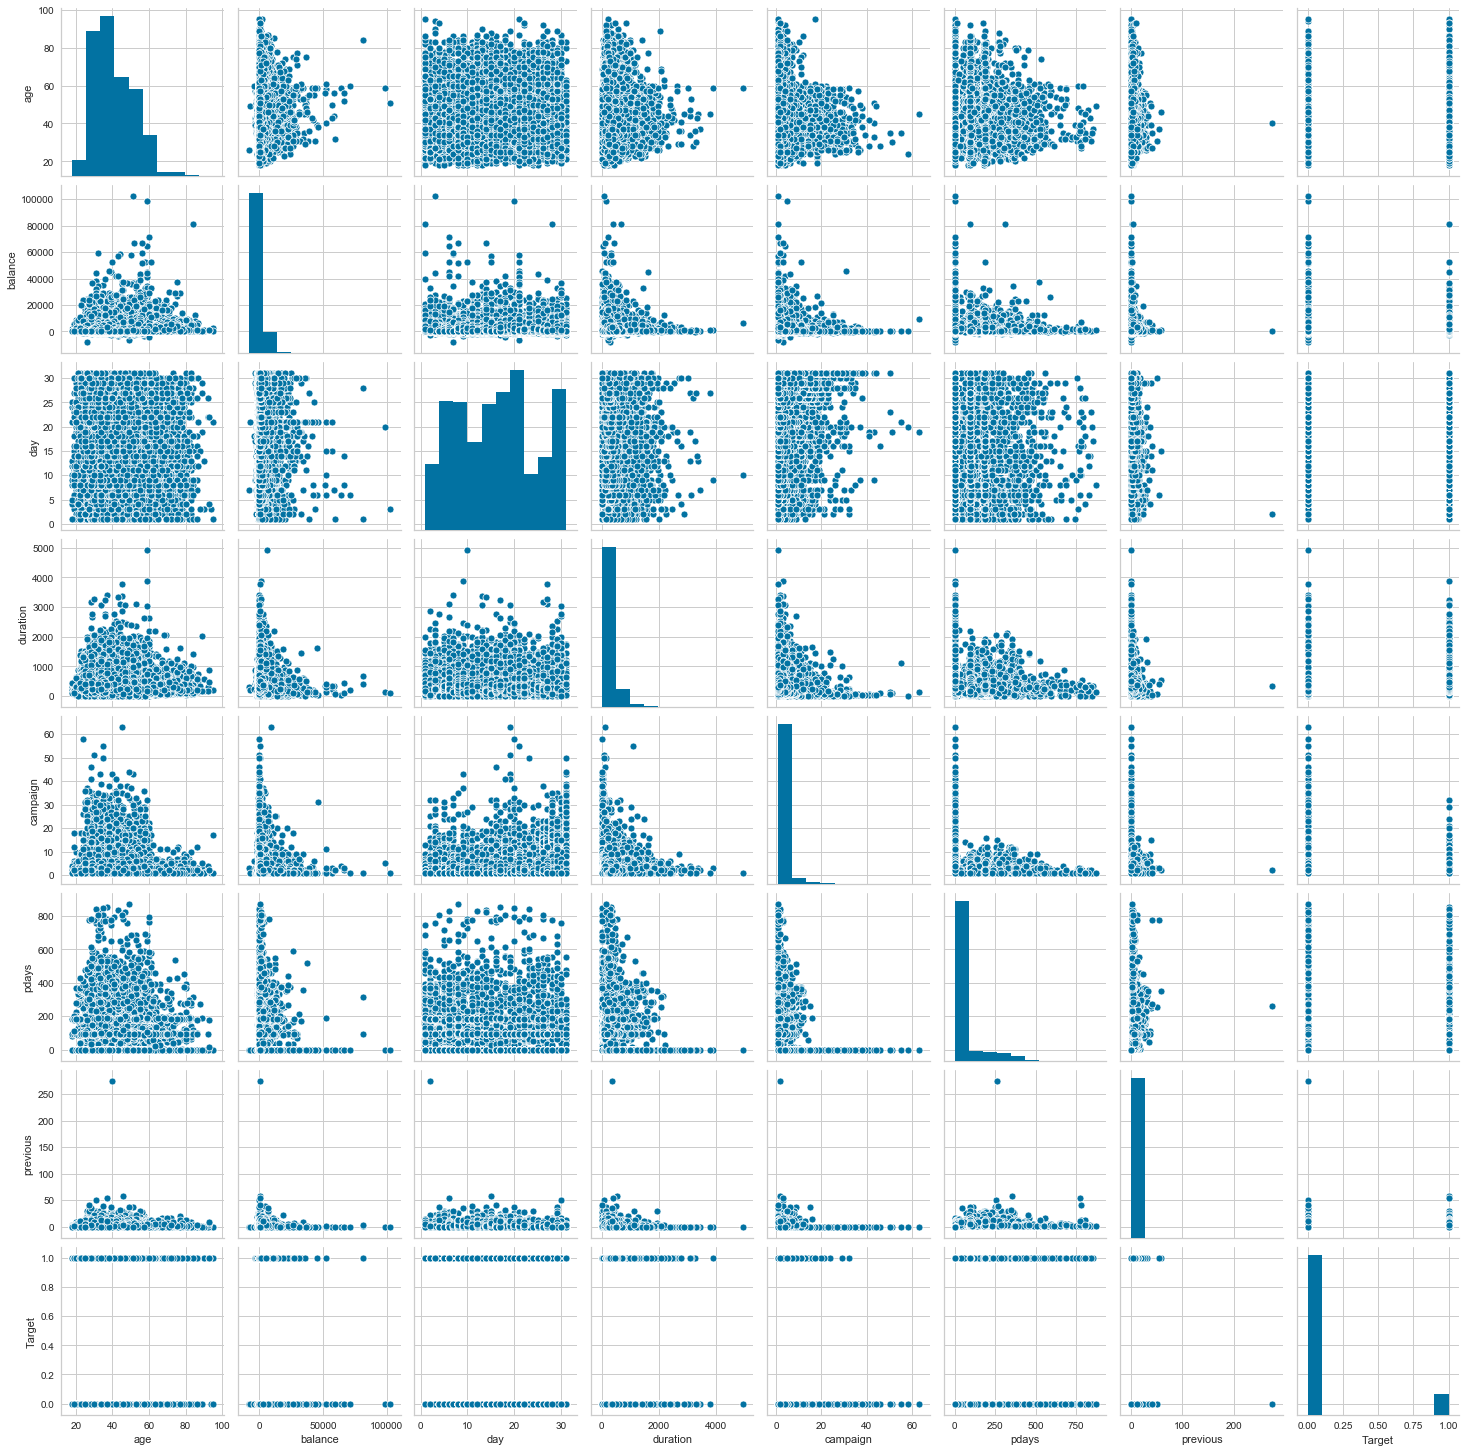

In [97]:
sns.pairplot(bankClientData)

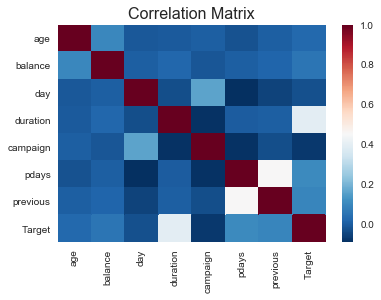

In [98]:
# Separate both dataframes into 
numeric_bankClientData = bankClientData.select_dtypes(exclude="category")
corr_numeric = numeric_bankClientData.corr()

sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

In [99]:
oneHotCols=["job","marital","education","default","housing","loan","contact","month","poutcome"]
bankClientData=pd.get_dummies(bankClientData, columns=oneHotCols)
bankClientData.head(10)


,age,balance,day,duration,campaign,pdays,previous,Target,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
5,35,231,5,139,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
6,28,447,5,217,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
7,42,2,5,380,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
8,58,121,5,50,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
9,43,593,5,55,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [100]:
print(bankClientData.Target.value_counts())

0    39922
1     5289
Name: Target, dtype: int64


# Observation:

Data has lots of outliers which I think indicates data is like that and so not using scaling or data processing for outliers

#### Split the bankClientData into training and test set in the ratio of 70:30 (Training:Test) based on dependent and independent variables.

In [101]:
# splitting data into training and test set for independent attributes
from sklearn.model_selection import train_test_split

features = [col for col in bankClientData.columns if col != 'Target']

X_train, X_test, y_train, y_test = train_test_split(bankClientData[features], bankClientData['Target'], test_size=.3, random_state=22)
X_train.shape, X_test.shape

((31647, 51), (13564, 51))

# Logistic Regression

In [102]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score,accuracy_score
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear', random_state=22)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=22, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [103]:
y_predict = logreg.predict(X_test)              # Predicting the target variable on test data

In [104]:
# Observe the predicted and observed classes in a dataframe.

z = X_test.copy()
z['Observed Target'] = y_test
z['Predicted Target'] = y_predict
z.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,Observed Target,Predicted Target
4793,35,592,21,74,1,-1,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
7650,27,437,30,275,2,-1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
24132,59,1026,5,669,1,-1,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
16740,52,7,24,150,5,-1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
37343,31,864,13,127,1,-1,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0


In [105]:
## function to get confusion matrix in a proper format

def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

Training accuracy 0.9025184061680412

Testing accuracy 0.8998083161309348

Confusion Matrix


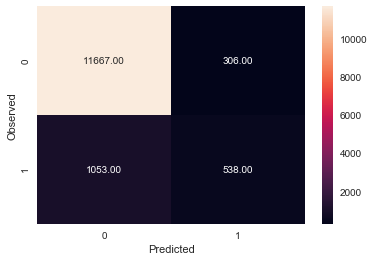

None

Recall: 0.3381521055939661

Precision: 0.6374407582938388

F1 Score: 0.44188911704312117

Roc Auc Score: 0.65629730060455


In [106]:
print("Training accuracy",logreg.score(X_train,y_train))  
print()
print("Testing accuracy",logreg.score(X_test, y_test))
print()
print('Confusion Matrix')
print(draw_cm(y_test,y_predict))
print()
print("Recall:",recall_score(y_test,y_predict))
print()
print("Precision:",precision_score(y_test,y_predict))
print()
print("F1 Score:",f1_score(y_test,y_predict))
print()
print("Roc Auc Score:",roc_auc_score(y_test,y_predict))

## Create the decision tree model using “gini” method of finding the split columns and fit it to training data.

In [107]:
# invoking the decision tree classifier function. Using 'gini' method of finding the split columns. Other option 
# could be gini index.  

model_gini = DecisionTreeClassifier(criterion='gini', random_state=22)

In [108]:
model_gini.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=22, splitter='best')

In [109]:
print("Train: %.2f" % model_gini.score(X_train, y_train))  # performance on train data
print("Test: %.2f" % model_gini.score(X_test, y_test))  # performance on test data

Train: 1.00
Test: 0.88


#### There is a high degree of overfitting in the model due to which the test accuracy drops drastically. This shows why decision trees are prone to overfitting. 

#### Regularize/prune the decision tree by limiting the max. depth of trees and print the accuracy.

In [110]:
clf_pruned = DecisionTreeClassifier(criterion = "gini", max_depth=4, random_state=22)
clf_pruned.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=22, splitter='best')

In [111]:
print("Train: %.2f" % clf_pruned.score(X_train, y_train))  # performance on train data
print("Test: %.2f" % clf_pruned.score(X_test, y_test))  # performance on test data

Train: 0.90
Test: 0.90


In [112]:
y_train.value_counts()

0    27949
1     3698
Name: Target, dtype: int64

In [113]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz

In [114]:
# dot_data = StringIO()
# export_graphviz(clf_pruned, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True,feature_names = features,class_names=['5','6','8'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('wines_pruned.png')
# Image(graph.create_png())
train_char_label = ['No', 'Yes']
Term_Deposit_File = open('term_deposit.dot','w')
dot_data = tree.export_graphviz(clf_pruned, out_file=Term_Deposit_File, feature_names = list(X_train), class_names = list(train_char_label))
Term_Deposit_File.close()

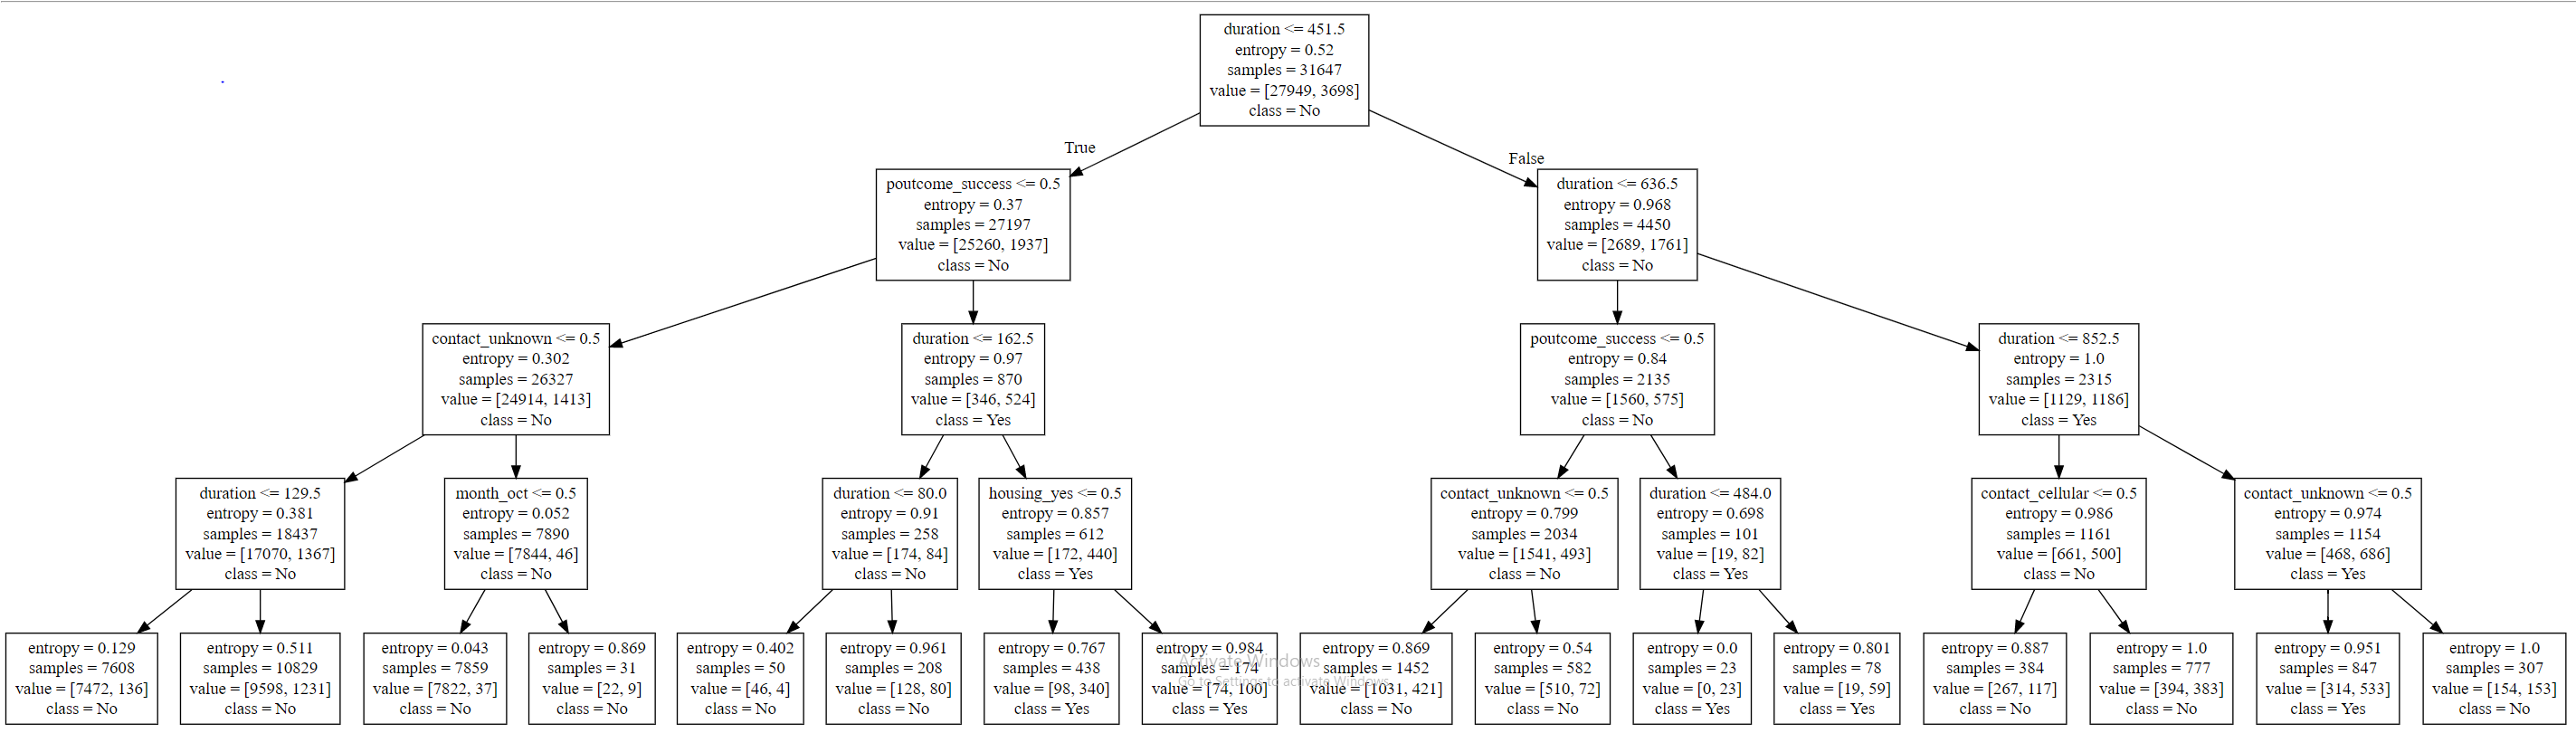

In [115]:
print (pd.DataFrame(clf_pruned.feature_importances_, columns = ["Imp"], index = X_train.columns))

                          Imp
age                  0.000000
balance              0.001470
day                  0.002552
duration             0.607555
campaign             0.000000
pdays                0.000000
previous             0.000000
job_admin.           0.000000
job_blue-collar      0.000000
job_entrepreneur     0.000000
job_housemaid        0.000000
job_management       0.000000
job_retired          0.000000
job_self-employed    0.000000
job_services         0.000000
job_student          0.000000
job_technician       0.000000
job_unemployed       0.000000
job_unknown          0.000000
marital_divorced     0.000000
marital_married      0.000000
marital_single       0.000000
education_primary    0.000000
education_secondary  0.000000
education_tertiary   0.000000
education_unknown    0.000000
default_no           0.000000
default_yes          0.000000
housing_no           0.000000
housing_yes          0.005004
loan_no              0.000000
loan_yes             0.000000
contact_ce

In [116]:
preds_train = clf_pruned.predict(X_train)
preds_test = clf_pruned.predict(X_test)

acc_DT = accuracy_score(y_test, preds_test)

In [117]:
acc_DT

0.9003981126511353

## Decision tree performance

In [118]:
# Confusion matrix
pd.crosstab(y_test, preds_test, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,11684,289
1,1062,529


C:\Users\rpatil\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


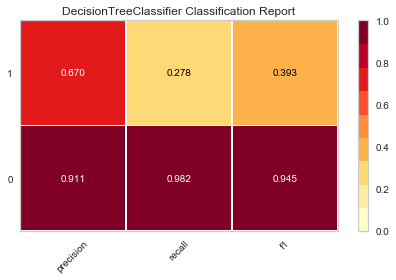

C:\Users\rpatil\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


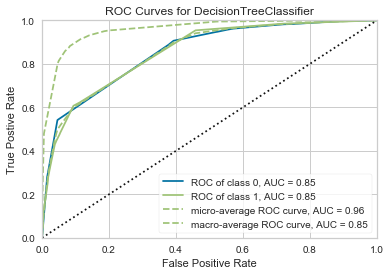

In [119]:
# Visualize model performance with yellowbrick library
from yellowbrick.classifier import ClassificationReport, ROCAUC
viz = ClassificationReport(DecisionTreeClassifier(criterion = "entropy", max_depth=4))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

roc = ROCAUC(DecisionTreeClassifier(criterion = "entropy", max_depth=4))
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show()

In [120]:
#Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.DataFrame({'Method':['Decision Tree'], 'accuracy': acc_DT})
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf

,Method,accuracy
0,Decision Tree,0.900398


### Apply the Random forest model and print the accuracy of Random forest Model

In [121]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators = 50)
rfcl = rfcl.fit(X_train, y_train)

In [122]:
pred_RF = rfcl.predict(X_test)
acc_RF = accuracy_score(y_test, pred_RF)

In [123]:
tempResultsDf = pd.DataFrame({'Method':['Random Forest'], 'accuracy': [acc_RF]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf

,Method,accuracy
0,Decision Tree,0.900398
0,Random Forest,0.905116


C:\Users\rpatil\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


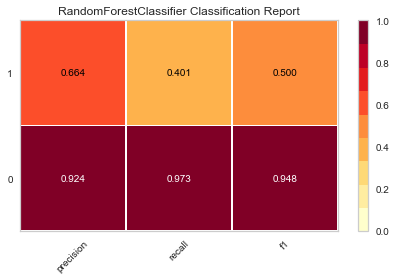

C:\Users\rpatil\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


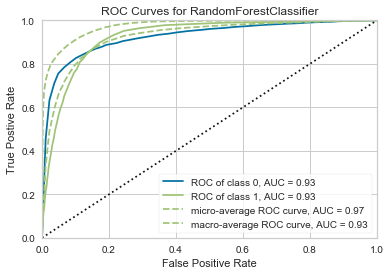

In [124]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(RandomForestClassifier(n_estimators = 50))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

roc = ROCAUC(RandomForestClassifier(n_estimators = 50))
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show()

#### Compared to the decision tree, we can see that the accuracy has significantly improved for the Random forest model

# Apply Adaboost Ensemble Algorithm for the same data and print the accuracy.

In [125]:
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier(n_estimators = 100, learning_rate=0.1, random_state=22)
abcl = abcl.fit(X_train, y_train)

In [126]:
pred_AB =abcl.predict(X_test)
acc_AB = accuracy_score(y_test, pred_AB)

In [127]:
tempResultsDf = pd.DataFrame({'Method':['Adaboost'], 'accuracy': [acc_AB]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf

,Method,accuracy
0,Decision Tree,0.900398
0,Random Forest,0.905116
0,Adaboost,0.895311


C:\Users\rpatil\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


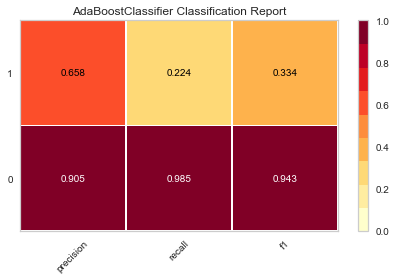

C:\Users\rpatil\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


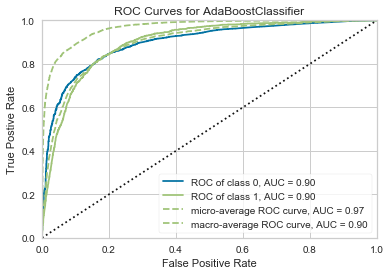

In [128]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(AdaBoostClassifier(n_estimators= 100, learning_rate=0.1, random_state=22))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

roc = ROCAUC(AdaBoostClassifier(n_estimators= 100, learning_rate=0.1, random_state=22))
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show()

# Apply Bagging Classifier Algorithm and print the accuracy.

In [129]:
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(n_estimators=50, max_samples= .7, bootstrap=True, oob_score=True, random_state=22)
bgcl = bgcl.fit(X_train, y_train)

In [130]:
pred_BG = bgcl.predict(X_test)
acc_BG = accuracy_score(y_test, pred_BG)

In [131]:
tempResultsDf = pd.DataFrame({'Method':['Bagging'], 'accuracy': [acc_BG]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf

,Method,accuracy
0,Decision Tree,0.900398
0,Random Forest,0.905116
0,Adaboost,0.895311
0,Bagging,0.904084


C:\Users\rpatil\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


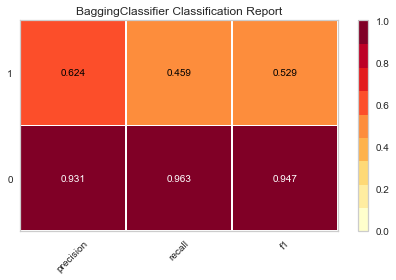

C:\Users\rpatil\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


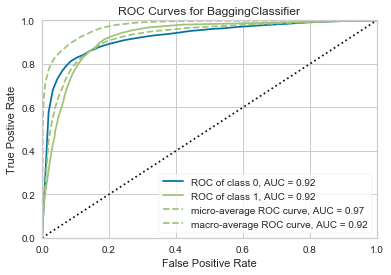

In [132]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(BaggingClassifier(n_estimators=50, max_samples= .7, bootstrap=True, oob_score=True, random_state=22))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

roc = ROCAUC(BaggingClassifier(n_estimators=50, max_samples= .7, bootstrap=True, oob_score=True, random_state=22))
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show()

# Apply GradientBoost Classifier Algorithm for the same data and print the accuracy

In [133]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22)
gbcl = gbcl.fit(X_train, y_train)

In [134]:
pred_GB = gbcl.predict(X_test)
acc_GB = accuracy_score(y_test, pred_GB)

In [135]:
tempResultsDf = pd.DataFrame({'Method':['Gradient Boost'], 'accuracy': [acc_GB]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf

,Method,accuracy
0,Decision Tree,0.900398
0,Random Forest,0.905116
0,Adaboost,0.895311
0,Bagging,0.904084
0,Gradient Boost,0.903273


C:\Users\rpatil\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


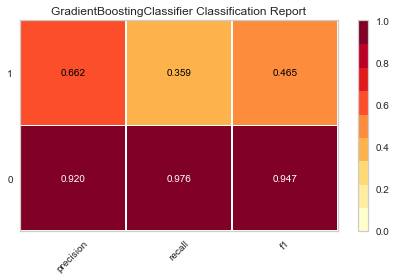

C:\Users\rpatil\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


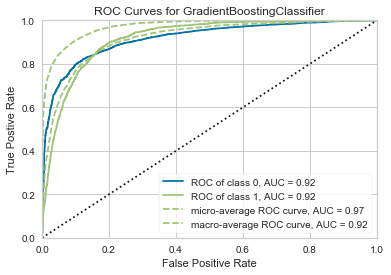

In [136]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

roc = ROCAUC(GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22))
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show()

## For this dataset, Random forest and bagging models give the best results on test predictions

In [137]:
# Creating a function for visualizing classifier results
def visClassifierResults(model_w_parameters):
    viz = ClassificationReport(model_w_parameters)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()

    roc = ROCAUC(model_w_parameters)
    roc.fit(X_train, y_train)
    roc.score(X_test, y_test)
    roc.show()

C:\Users\rpatil\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


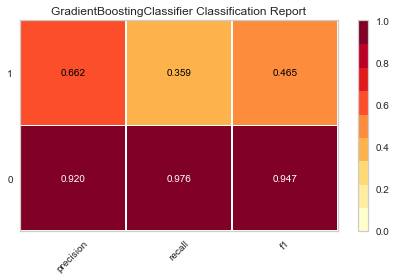

C:\Users\rpatil\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


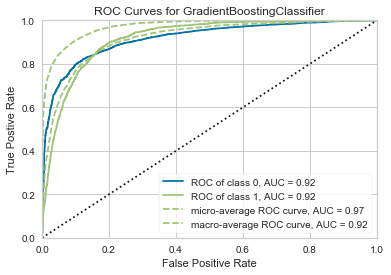

In [138]:
visClassifierResults(GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22))

C:\Users\rpatil\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


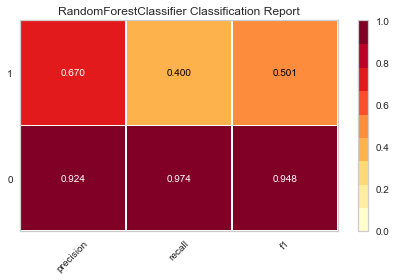

C:\Users\rpatil\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


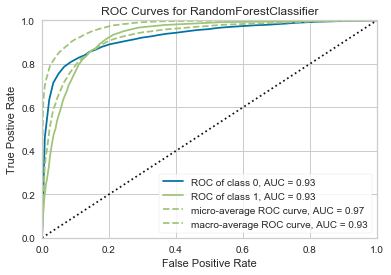

In [139]:
visClassifierResults(RandomForestClassifier(n_estimators = 50))

### Business Conclusion

**Confusion matrix means: 1 is client subscribe to term deposit and 0 means does not suscribe to term deposit**

*True Positive (observed=1,predicted=1)*
Predicted, Client will subscribe to term deposit and the client does subscribe to term deposit.

*False Positive (observed=0,predicted=1):*
Predicted, Client will subscribe to term deposit and the client does not subscribe to term deposit.

*True Negative (observed=0,predicted=0):*
Predicted, Client will not subscribe to term deposit and the client does not subscribe to term deposit.

*False Negative (observed=1,predicted=0):*
Predicted, Client will not subscribe to term deposit and the client does subscribe to term deposit.

Here more focus should be towards recall because our target variable is 'Subscribtion to term deposit' , i.e whether the client is subscribing to term deposit or not. And the bank wants more people to subscribe to term deposit i.e. less number of False Negative, so that bank doesn't lose real client who want to subscribe. Hence the focus should be on increasing Recall.

After achieving the desired accuracy we can deploy the model for practical use. As the bank now can predict who will say yes to subscribe to term deposit. They can use the model for upcoming clients.